In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install fastparquet
!sudo apt-get install libsnappy-dev
!python3 -m pip install  python-snappy
!python3 -m pip install pyarrow
! pip install hyperas

     |████████████████████████████████| 1.2 MB 13.1 MB/s 
     |████████████████████████████████| 125 kB 38.6 MB/s 
     |████████████████████████████████| 1.5 MB 50.1 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=348185 sha256=b713e251ab7d62812922fabee544453d6fe5c85997b5da9bb6447c4f0a2a21a9
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsnappy-dev
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 27.2 kB of archives.
After this operation, 108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy-dev amd64 1.1.7-1 [27.2 kB]
Fetched 27.2 kB in 0s (739 kB/s)
debconf: unable to init

In [3]:
import re
import os 
import numpy as np
import pandas as pd

from sklearn.metrics import precision_score, recall_score, accuracy_score
#from imblearn.under_sampling import EditedNearestNeighbours

os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from viz_functions import plot_2Dcyto


os.chdir('/content/gdrive/My Drive/data/SWINGS/L2')

############################################################
# Training of other algorithms on the unbiased dataset
############################################################

import pickle
import fastparquet as fp
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import load_model, model_from_json

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight

from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

cluster_classes = ['MICRO', 'ORGNANO', 'ORGPICOPRO', 'REDNANO', 'REDPICOEUK',\
                   'REDPICOPRO', 'inf1microm','sup1microm']

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def clf_eval(params):
    ''' Wrapper around classifiers for them to be fed into hyperopt '''
    classif = params['classif']
    del params['classif']
    
    if classif == 'knn':
        params['n_neighbors'] = int(params['n_neighbors'])
        clf = KNeighborsClassifier(**params)
    elif classif == 'svm':
        params['C'] = int(params['C'])
        clf = svm.LinearSVC(**params)
    elif classif == 'lgbm':
        params['n_estimators'] = int(params['n_estimators'])
        clf = LGBMClassifier(**params)
        
    clf.fit(X_train, y_train)

    if classif == 'svm':
        pred_valid = clf.predict(X_valid)
        w = compute_sample_weight(params['class_weight'], y_valid)
        accuracy = accuracy_score(y_valid, pred_valid, sample_weight = w)
        ll = accuracy_score(y_valid, pred_valid, sample_weight = w)
    else:
        ll = log_loss(y_valid, clf.predict_proba(X_valid)) # No sample weight in KNN
    
    return {'loss': ll, 'status': STATUS_OK}

In [5]:
# Import Pulse data 
train = np.load('Listmodes/train.npz', allow_pickle = True)
X_train = train['X']
y_train = train['y']

valid = np.load('Listmodes/valid.npz', allow_pickle = True)
X_valid = valid['X']
y_valid = valid['y']

In [ ]:
X_train.shape

(57241, 67)

In [6]:
# Load nomenclature
tn = pd.read_csv('Pulse/train_test_nomenclature.csv')
tn.columns = ['name', 'id']

In [7]:
y_train = y_train.argmax(1)
y_valid = y_valid.argmax(1)

In [8]:
#************************************
# Looking for the best hyperparams 
#************************************
algo=tpe.suggest
nb_evals = 30

class_names, nb_samples  = np.unique(y_train, return_counts = True)
reweighted = dict(zip(class_names, 1/ nb_samples))
equal_weights = dict(zip(class_names, np.full(len(class_names), 1 / len(class_names))))
class_weight = (reweighted,)

# Lgbm
lr = (1e-3, 1e-2)
n_est = (10, 1200, 1) # Peut mettre encore plus que 1000 ?
num_leaves = (6,8,12,16)
bt = ('gbdt', 'dart')
objective = ('binary')
max_bin = (255, 510)
colsample_bytree = (0.64, 0.65, 0.66)
subsample = (0.7,0.75)
reg_alpha = (1,1.2)
reg_lambda = (1,1.2,1.4)
is_unbalance = (True, False)
class_weight = (reweighted, equal_weights)


lgbm_params = {
    'classif': 'lgbm',
    'eval_metric': 'logloss', 
    'learning_rate': hp.uniform('learning_rate', *lr),
    'n_estimators': hp.quniform('n_estimators', *n_est),
    'num_leaves': hp.choice('num_leaves', num_leaves), # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type': hp.choice('boosting_type', bt), # for better accuracy -> try dart
    'objective': hp.choice('objective', objective),
    'max_bin': hp.choice('max_bin', max_bin), # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree': hp.choice('colsample_bytree', colsample_bytree),
    'subsample': hp.choice('subsample', subsample),
    'reg_alpha': hp.choice('reg_alpha', reg_alpha),
    'reg_lambda':  hp.choice('reg_lambda', reg_lambda),
    'is_unbalance': hp.choice('is_unbalance', is_unbalance),
    'class_weight': equal_weights, 'n_jobs': -1 
    }


In [9]:
lgbm_best = fmin(
    fn=clf_eval, 
    space=lgbm_params,
    algo=algo,
    max_evals = nb_evals)

100%|██████████| 30/30 [1:07:26<00:00, 134.89s/it, best loss: 0.0485325647013883]


In [10]:
os.chdir('/content/gdrive/My Drive/Models/SWINGS/')

In [11]:
# Store the best specification
with open('lgbm_best_trainweights.pickle', 'wb') as handle:
    pickle.dump(lgbm_best, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Store the best specification
with open('lgbm_best.pickle', 'rb') as handle:
    lgbm_best = pickle.load(handle)

In [13]:
# LGBM
lgbm = LGBMClassifier(eval_metric = 'logloss',
    learning_rate = lgbm_best['learning_rate'],
    n_estimators = int(lgbm_best['n_estimators']),
    num_leaves = num_leaves[lgbm_best['num_leaves']], # large num_leaves helps improve accuracy but might lead to over-fitting
    boosting_type = bt[lgbm_best['boosting_type']], # for better accuracy -> try dart
    objective = objective[lgbm_best['objective']],
    max_bin = max_bin[lgbm_best['max_bin']], # large max_bin helps improve accuracy but might slow down training progress
    colsample_bytree = colsample_bytree[lgbm_best['colsample_bytree']],
    subsample = subsample[lgbm_best['subsample']],
    reg_alpha = reg_alpha[lgbm_best['reg_alpha']],
    reg_lambda = reg_lambda[lgbm_best['reg_lambda']],
    is_unbalance = is_unbalance[lgbm_best['is_unbalance']],
    class_weight = equal_weights)

lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.125, 1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125,
                             5: 0.125, 6: 0.125, 7: 0.125},
               colsample_bytree=0.66, eval_metric='logloss',
               importance_type='split', is_unbalance=False,
               learning_rate=0.00846585082213754, max_bin=510, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=762, n_jobs=-1, num_leaves=16, objective='b',
               random_state=None, reg_alpha=1.2, reg_lambda=1.2, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [14]:
test = np.load('/content/gdrive/My Drive/data/SWINGS/L2/Listmodes/test.npz')
X_test = test['X']
y_test = test['y']
y_test = y_test.argmax(1)

In [15]:
preds = lgbm.predict(X_test)

In [16]:
print("Evaluation of best performing model:")
class_accuracy = precision_score(y_test, preds, average = None, labels = list(set(y_test)))

print('Micro accuracy: ', precision_score(y_test, preds,\
                                average = 'micro', labels = list(set(y_test))))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(y_test, preds,\
                                average = 'macro', labels = list(set(y_test))))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(y_test, preds,\
                    labels = tn['id']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9853002771514887
Classes accuracy:  {'MICRO': 0.9521739130434783, 'ORGNANO': 0.8620689655172413, 'ORGPICOPRO': 0.9950513894175866, 'REDNANO': 0.7563247470101196, 'REDPICOEUK': 0.9981088463963017, 'REDPICOPRO': 0.9799761304866729, 'inf1microm': 0.9972349517566758, 'sup1microm': 0.937370867768595}
Macro accuracy:  0.9347887264245839


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         219        0           0        0           0           0   
ORGNANO         0      100           0       13           0           0   
ORGPICOPRO      0        0       15684        0           0           0   
REDNANO         3        3           0     6577          45           0   
REDPICOEUK      0        1          10     2065       80750           0   
REDPICOPRO      0        0          14        0           0        7390   
inf1micro

In [ ]:
print("Evaluation of best performing model:")
class_accuracy = precision_score(y_test, preds, average = None, labels = list(set(y_test)))

print('Micro accuracy: ', precision_score(y_test, preds,\
                                average = 'micro', labels = list(set(y_test))))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(y_test, preds,\
                                average = 'macro', labels = list(set(y_test))))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(y_test, preds,\
                    labels = tn['id']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9907162516343576
Classes accuracy:  {'MICRO': 0.9601769911504425, 'ORGNANO': 0.8803418803418803, 'ORGPICOPRO': 0.9963702359346642, 'REDNANO': 0.771511692961844, 'REDPICOEUK': 0.99875149033811, 'inf1microm': 0.9066265060240963, 'sup1microm': 0.999356604505811}
Macro accuracy:  0.9248181591210112


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  inf1microm  \
name                                                                      
MICRO         217        0           0        0           0           0   
ORGNANO         0      103           0       16           0           0   
ORGPICOPRO      0        0       34587        0           0           0   
REDNANO         3        5           0     6895          36           0   
REDPICOEUK      0        1           9     1993       88795           0   
inf1microm      0        0           2        0           0        1505   
sup1microm      0        0         107        

# Valid

In [ ]:
preds = lgbm.predict(X_valid)
print("Evaluation of best performing model:")
class_accuracy = precision_score(y_valid, preds, average = None, labels = list(set(y_valid)))

print('Micro accuracy: ', precision_score(y_valid, preds,\
                                average = 'micro', labels = list(set(y_valid))))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(y_valid, preds,\
                                average = 'macro', labels = list(set(y_valid))))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(y_valid, preds,\
                    labels = tn['id']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9830585232888339
Classes accuracy:  {'MICRO': 0.89171974522293, 'ORGNANO': 0.966996699669967, 'ORGPICOPRO': 0.9946827276850965, 'REDNANO': 0.8601733281593584, 'REDPICOEUK': 0.9943666691098709, 'inf1microm': 0.7902823122719416, 'sup1microm': 0.9981366595786658}
Macro accuracy:  0.9198706124949989


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  inf1microm  \
name                                                                      
MICRO         700        0           0        1           0           0   
ORGNANO         7     1172           0       32           0           0   
ORGPICOPRO      0        0       39471        0           0          48   
REDNANO        55       23           0    13300         132           0   
REDPICOEUK      0        8          25     2055       94965           0   
inf1microm      0        0           4        0           0        4115   
sup1microm      0        0         168       

# Import other files

In [ ]:
%pwd

'/content/gdrive/My Drive/data/SWINGS/L2'

In [ ]:
os.chdir('../hardtoclassify/Listmodes')
files = os.listdir()

In [ ]:
from scipy.integrate import trapz
for file in files:
  X_file = pd.read_csv(file, sep = ';', decimal = ',')
  print(X_file.columns)

23000


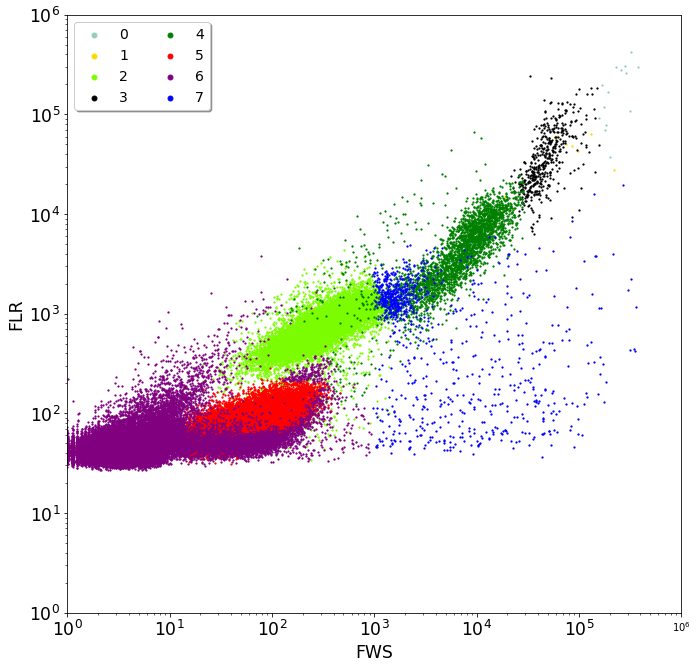

30844


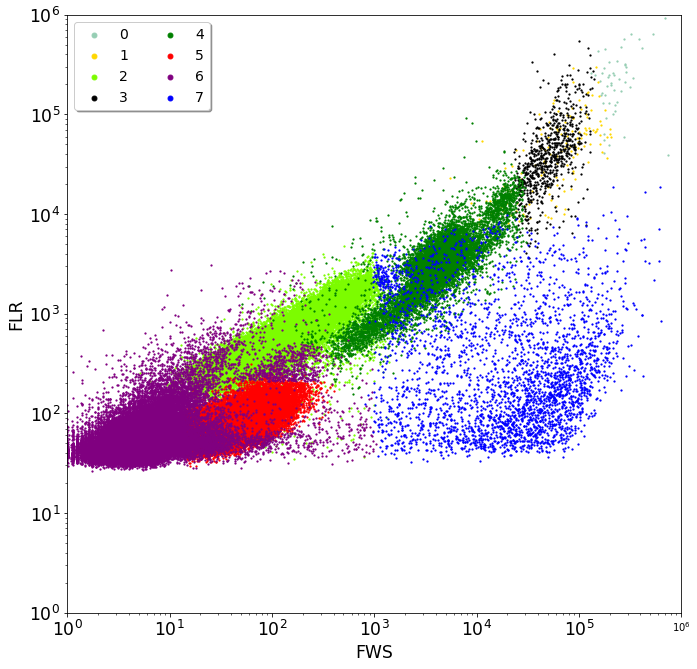

13075


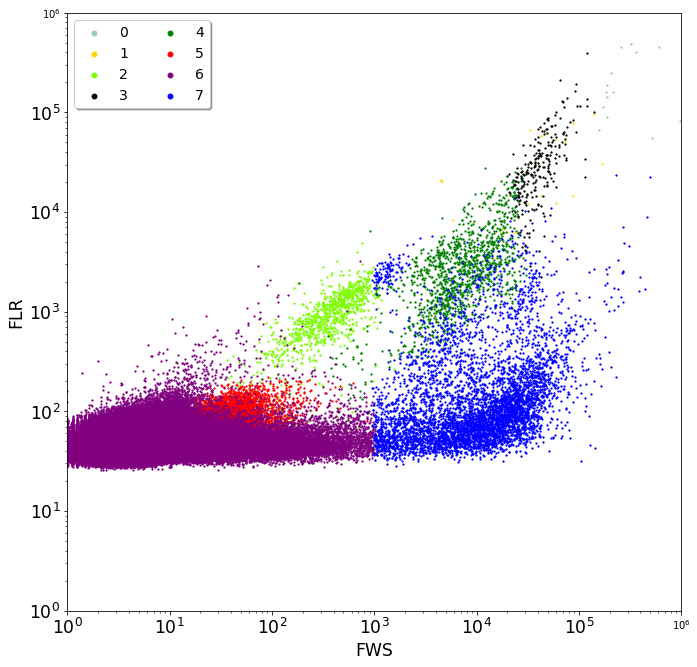

In [ ]:
for file in files:
  X_file = pd.read_csv(file, sep = ';', decimal = ',')
  preds = lgbm.predict(X_file.values)
  print((preds == 5).sum())
  XX =  X_file[['FWS Total', 'SWS Total', 'FL Red Total', 'Fl Yellow Total', 'Curvature Total']]
  XX.columns = ['FWS', 'SWS', 'FLR', 'FlY', 'Curvature']
  yy = preds
  plot_2Dcyto(XX, yy.astype(str), q1 = 'FWS', q2 = 'FLR', str_labels = True)

In [ ]:
23000
30844
13075

24154

In [ ]:
X_file.set_index('Particle ID')

(110816, 67)

In [ ]:
X_file.shape

(110816, 68)